# **TikTok Project – Predictive Modelling (part 4)**

In *Part 1* acquainted us with the raw data, *part 2* explored distributions visually, and *part 3* confirmed key patterns via hypothesis testing. Here, in *part 4*, as requested by the project manger of our team we will proceed to the next step: the construction of our first predictive model (based on linear regression) to predict the verified_status vsriable we focused on previously from the other main varibles in the datset.

**The purpose** of this project is:
1. engineer additional features and balance the classes,
2. build a logistic‐regression classifier to predict whether a channel is verified, and
3. interpret the model’s performance and coefficients.

**The goal** deliver a simple interpretable model that not only discriminates verified from non‑verified channels with high accuracy but also highlights the relative influence of each predictor.

Let's start from importing the necessary libraries and load the dataset ...

In [1]:
# Data wrangling imports
import pandas as pd
import numpy as np

# Visualisation imports
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm
import seaborn as sns

# Modelling imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import resample

# Read the dataset and display the first few rows
data = pd.read_csv("tiktok_dataset.csv")
data.head()

,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0


Clean missing values:

In [2]:
# Check for missing values
missing_values = data.isna().sum()
# Print number of missing values in each column
print("Missing values in each column (initially):")
print(missing_values)
# Drop rows with missing values
data = data.dropna(axis=0)
missing_values_after = data.isna().sum()
# Print number of missing values in each column
print("Missing values in each column (after cleaning):")
print(missing_values_after)
# Check for duplicates
print("Number of duplicate rows in the dataset:")
data.duplicated().sum()

Missing values in each column (initially):
#                             0
claim_status                298
video_id                      0
video_duration_sec            0
video_transcription_text    298
verified_status               0
author_ban_status             0
video_view_count            298
video_like_count            298
video_share_count           298
video_download_count        298
video_comment_count         298
dtype: int64
Missing values in each column (after cleaning):
#                           0
claim_status                0
video_id                    0
video_duration_sec          0
video_transcription_text    0
verified_status             0
author_ban_status           0
video_view_count            0
video_like_count            0
video_share_count           0
video_download_count        0
video_comment_count         0
dtype: int64
Number of duplicate rows in the dataset:


np.int64(0)

Our exploratory analysis revealed extreme outliers in video_like_count and video_comment_count. To prevent these values from disproportionately skewing our logistic regression, we’ll cap them at sensible thresholds.

In [3]:
# Check for and handle outliers (video_view_count)
percentile25 = data["video_like_count"].quantile(0.25)
percentile75 = data["video_like_count"].quantile(0.75)
iqr = percentile75 - percentile25
upper_limit = percentile75 + 1.5 * iqr
# Print nuber of outliers
isabove = data["video_like_count"] > upper_limit
print("Number of outliers in video_like_count:")
print(isabove.sum())
# Cap the outliers to the upper limit
data.loc[data["video_like_count"] > upper_limit, "video_like_count"] = upper_limit

# Check for and handle outliers (video_duration_sec)
percentile25 = data["video_comment_count"].quantile(0.25)
percentile75 = data["video_comment_count"].quantile(0.75)
iqr = percentile75 - percentile25
upper_limit = percentile75 + 1.5 * iqr
# Print nuber of outliers
isabove = data["video_comment_count"] > upper_limit
print("Number of outliers in video_comment_count:")
print(isabove.sum())
# Cap the outliers to the upper limit
data.loc[data["video_comment_count"] > upper_limit, "video_comment_count"] = upper_limit

Number of outliers in video_like_count:
1726
Number of outliers in video_comment_count:
2789


Let's now check for class balance:

In [4]:
# Check class balance
data["verified_status"].value_counts()

verified_status
not verified    17884
verified         1200
Name: count, dtype: int64

...the response variable for this model is **`verified_status`**. Because verified channels are comparatively rare, we up‑sample the minority class to avoid bias. 

In [5]:
# Separate majority and minority classes
major = data.loc[data['verified_status'] == 'not verified']
minor = data.loc[data['verified_status'] == 'verified']

# Upsample minority to the size of majority
minor_upsampled = resample(minor,
                           replace=True,
                           n_samples=len(major),
                           random_state=0)

# Combine and shuffle
data_balanced = pd.concat([major, minor_upsampled]).sample(frac=1, random_state=0).reset_index(drop=True)

# Sanity‑check new class counts
data_balanced['verified_status'].value_counts()

verified_status
verified        17884
not verified    17884
Name: count, dtype: int64

Now let's engineer a simple extra feature that could be useful for our predictive modeling work. Text length often proxies for information density and may interact with user engagement. Let's also inspect its distribution per verification status.

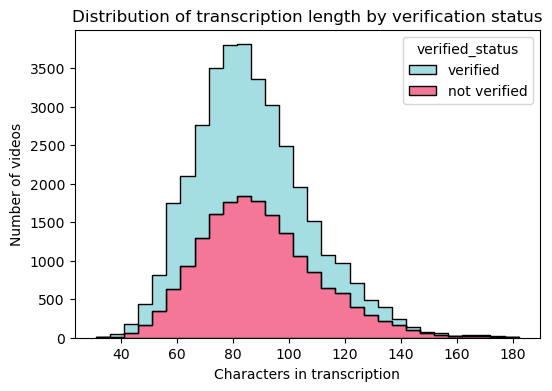

In [6]:
# Engineer simple feature: character length of the video transcription
data_balanced['text_length'] = data_balanced['video_transcription_text'].str.len()

# Define colours to use
tiktok_palette = {
    'verified': '#69C9D0',   # tiktok cyan
    'not verified': '#EE1D52'    # tiktok magenta
}

# Visualise the distribution of transcription length by verification status
plt.figure(figsize=(6, 4))
sns.histplot(
    data=data_balanced,
    x='text_length',
    hue='verified_status',
    bins=30,
    element='step',
    stat='count',
    multiple='stack',
    palette=tiktok_palette,
    alpha=0.6
)
plt.title('Distribution of transcription length by verification status')
plt.xlabel('Characters in transcription')
plt.ylabel('Number of videos')
plt.show()

Finally, a quick correlation heatmap of the numeric variables (to get an overall sense of the dependencies between them):

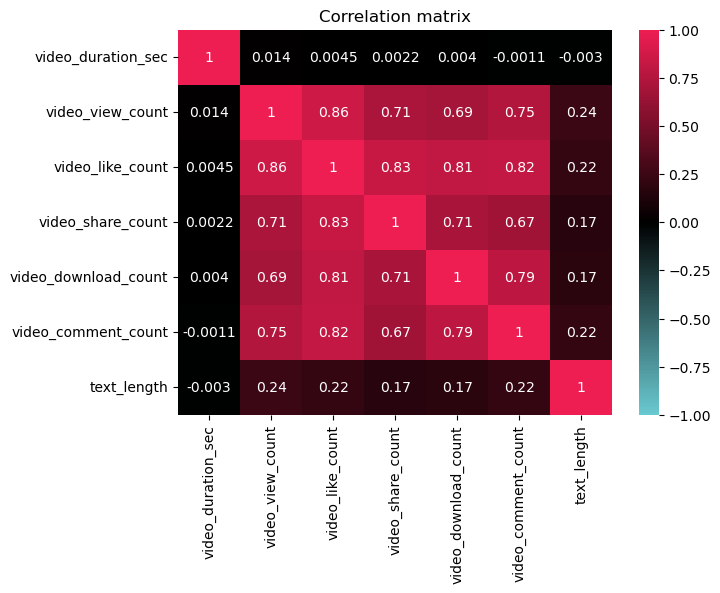

In [7]:
# Select features and target variable
num_cols = ['video_duration_sec', 'video_view_count', 'video_like_count',
            'video_share_count', 'video_download_count', 'video_comment_count',
              'text_length']

# Define tiktok three‑node colormap: cyan → black → magenta
colors = ['#69C9D0', 'black', '#EE1D52']
tiktok_cmap = LinearSegmentedColormap.from_list('tiktok_three', colors)
# Diverging normalisation centred at zero (since corr values range –1 to 1)
norm = TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)

# Visualise the correlation matrix of numeric features
plt.figure(figsize=(7, 5))
sns.heatmap(
    data_balanced[num_cols].corr(),
    annot=True,
    cmap=tiktok_cmap,
    norm=norm
)
plt.title('Correlation matrix')
plt.show()

Let's get ready to build the model now. Let's select a parsimonious feature set that still captures engagement and content characteristics:

* continuous: duration, view, share, download, comments
* categorical: claim status, author ban status

The target remains binary **`verified_status`**.

In [8]:
# Select target variable and features
y = data_balanced['verified_status']
X = data_balanced[["video_duration_sec", "claim_status", "author_ban_status",
                    "video_view_count", "video_share_count", "video_download_count",
                      "video_comment_count"]]

# Perform train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=0)

# Print the shapes of the training and test sets
print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)
print("Training set target shape:", y_train.shape)
print("Test set target shape:", y_test.shape)

Training set shape: (26826, 7)
Test set shape: (8942, 7)
Training set target shape: (26826,)
Test set target shape: (8942,)


Let's check features datatype (starting from training set):

In [9]:
# Check data types
X_train.dtypes

video_duration_sec        int64
claim_status             object
author_ban_status        object
video_view_count        float64
video_share_count       float64
video_download_count    float64
video_comment_count     float64
dtype: object

In [10]:
# Get unique values in `claim_status`
print("Unique values in claim_status:")
print(X_train["claim_status"].unique())
# Get unique values in `author_ban_status`
print("Unique values in author_ban_status:")
print(X_train["author_ban_status"].unique())

Unique values in claim_status:
['claim' 'opinion']
Unique values in author_ban_status:
['active' 'under review' 'banned']


Since `claim_status` and `author_ban_status` are nominal, before using them in a logistic regression model we have to apply a one‑hot encoding function (dropping the first level to avoid multicollinearity). Let's start from the training set.

In [11]:
# Select the training features that needs to be encoded
X_train_to_encode = X_train[["claim_status", "author_ban_status"]]
# Display first few rows
X_train_to_encode.head()

,claim_status,author_ban_status
33058,claim,active
20491,claim,active
25583,claim,active
18474,claim,active
27312,opinion,active


In [12]:
# Set up an encoder for one-hot encoding the categorical features
X_encoder = OneHotEncoder(drop='first', sparse_output=False)
# Fit and transform the training features using the encoder
X_train_encoded = X_encoder.fit_transform(X_train_to_encode)
# Get feature names from encoder
X_encoder.get_feature_names_out()
# Place encoded training features (which is currently an array) into a dataframe
X_train_encoded_df = pd.DataFrame(data=X_train_encoded, columns=X_encoder.get_feature_names_out())
# Display first few rows
X_train_encoded_df.head()

,claim_status_opinion,author_ban_status_banned,author_ban_status_under review
0,0.0,0.0,0.0
1,0.0,0.0,0.0
2,0.0,0.0,0.0
3,0.0,0.0,0.0
4,1.0,0.0,0.0


In [13]:
# Concatenate numeric and encoded categorical test features
X_train_final = pd.concat([X_train.drop(columns=["claim_status", "author_ban_status"]).reset_index(drop=True), X_train_encoded_df], axis=1)
# Display first few rows
X_train_final.head()

,video_duration_sec,video_view_count,video_share_count,video_download_count,video_comment_count,claim_status_opinion,author_ban_status_banned,author_ban_status_under review
0,28,448458.0,60690.0,1811.0,501.0,0.0,0.0,0.0
1,21,776792.0,62539.0,1507.0,728.5,0.0,0.0,0.0
2,12,986641.0,35045.0,2336.0,460.0,0.0,0.0,0.0
3,57,551385.0,6744.0,982.0,144.0,0.0,0.0,0.0
4,33,8553.0,330.0,26.0,3.0,1.0,0.0,0.0


Let's do the same for the from the test set.

In [14]:
# Select the test features that needs to be encoded
X_test_to_encode = X_test[["claim_status", "author_ban_status"]]
# Transform the test features using the already‑fitted encoder
X_test_encoded = X_encoder.transform(X_test_to_encode)
# Build a DataFrame with the encoded test features
X_test_encoded_df = pd.DataFrame(data=X_test_encoded, columns=X_encoder.get_feature_names_out())
# Concatenate numeric and encoded categorical test features
X_test_final = pd.concat([X_test.drop(columns=["claim_status", "author_ban_status"]).reset_index(drop=True),X_test_encoded_df.reset_index(drop=True)],axis=1)
# Display first few rows
X_test_final.head()

,video_duration_sec,video_view_count,video_share_count,video_download_count,video_comment_count,claim_status_opinion,author_ban_status_banned,author_ban_status_under review
0,60,398688.0,47206.0,1481.0,728.5,0.0,0.0,0.0
1,27,3060.0,204.0,11.0,2.0,1.0,0.0,0.0
2,31,5316.0,52.0,25.0,4.0,1.0,0.0,0.0
3,34,362662.0,37785.0,5888.0,728.5,0.0,0.0,0.0
4,12,9183.0,6.0,1.0,0.0,1.0,0.0,0.0


In [15]:
# Print the shapes of the training and test sets
print("Training set shape:", X_train_final.shape)
print("Test set shape:", X_test_final.shape)
print("Training set target shape:", y_train.shape)
print("Test set target shape:", y_test.shape)

Training set shape: (26826, 8)
Test set shape: (8942, 8)
Training set target shape: (26826,)
Test set target shape: (8942,)


In [16]:
# Check data types
X_train_final.dtypes

video_duration_sec                  int64
video_view_count                  float64
video_share_count                 float64
video_download_count              float64
video_comment_count               float64
claim_status_opinion              float64
author_ban_status_banned          float64
author_ban_status_under review    float64
dtype: object

In [17]:
# Encode the target variable (`verified_status`) using one-hot encoding: training set
y_encoder = OneHotEncoder(drop='first', sparse_output=False)
y_train_final = y_encoder.fit_transform(y_train.values.reshape(-1, 1)).ravel()
print("Encoded target variable shape (training):", y_train_final.shape)
print(y_train_final)
# Encode the target variable (`verified_status`) using one-hot encoding: training set
y_test_final = y_encoder.transform(y_test.values.reshape(-1, 1)).ravel()
print("Encoded target variable shape (test):", y_test_final.shape)
print(y_test_final)

Encoded target variable shape (training): (26826,)
[0. 0. 0. ... 1. 0. 0.]
Encoded target variable shape (test): (8942,)
[0. 0. 1. ... 1. 1. 0.]


Now that everything is organized and encoded properly we are ready. Let's finally train the model and evaluate its performance ...

In [18]:
# Train a logistic regression model
log_reg = LogisticRegression(max_iter=1000, random_state=0)
log_reg.fit(X_train_final, y_train_final)
# Make predictions on the test set
y_pred = log_reg.predict(X_test_final)
# Print classification report
print(classification_report(
    y_test_final, 
    y_pred, 
    target_names=['not verified', 'verified']
))

              precision    recall  f1-score   support

not verified       0.74      0.52      0.61      4450
    verified       0.63      0.82      0.72      4492

    accuracy                           0.67      8942
   macro avg       0.69      0.67      0.66      8942
weighted avg       0.69      0.67      0.67      8942



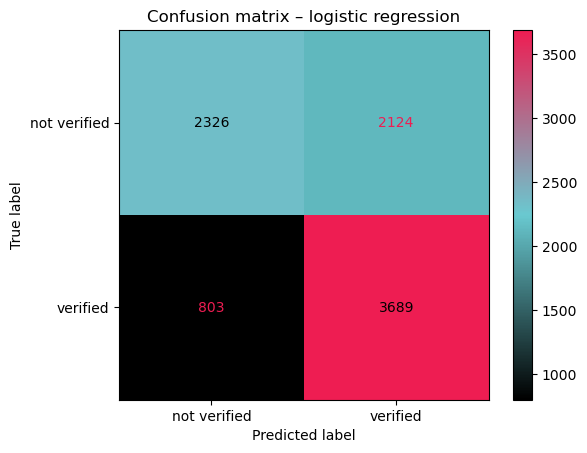

In [19]:
# Define a 3‑node colormap: low→black, mid→blue, high→red
custom_cmap = LinearSegmentedColormap.from_list(
    'black_blue_red',
    ['black','#69C9D0', '#EE1D52']
)

# Get the confusion matrix
cm = confusion_matrix(y_test_final, y_pred)

# Plot the confusion matrix with custom colormap
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=['not verified', 'verified']
)
disp.plot(cmap=custom_cmap)
plt.title('Confusion matrix – logistic regression')
plt.show()

Let's explore the best fit model coefficients now:

In [20]:
# Display the model coefficients
pd.DataFrame(data={"Feature Name":log_reg.feature_names_in_, "Model Coefficient":log_reg.coef_[0]})

,Feature Name,Model Coefficient
0,video_duration_sec,-3.160936e-03
1,video_view_count,-2.193988e-07
2,video_share_count,4.711228e-06
3,video_download_count,-7.758700e-05
4,video_comment_count,3.498029e-04
5,claim_status_opinion,1.639333e+00
6,author_ban_status_banned,-4.254828e-01
7,author_ban_status_under review,-1.002707e-01


For interpretability, we examine the **odds ratios** (exponential of the coefficients).  
Positive values (>1) increase the likelihood of verification, negative (<1) decrease it.

claim_status_opinion              5.151733
video_comment_count               1.000350
video_share_count                 1.000005
video_view_count                  1.000000
video_download_count              0.999922
video_duration_sec                0.996844
author_ban_status_under review    0.904593
author_ban_status_banned          0.653454
dtype: float64


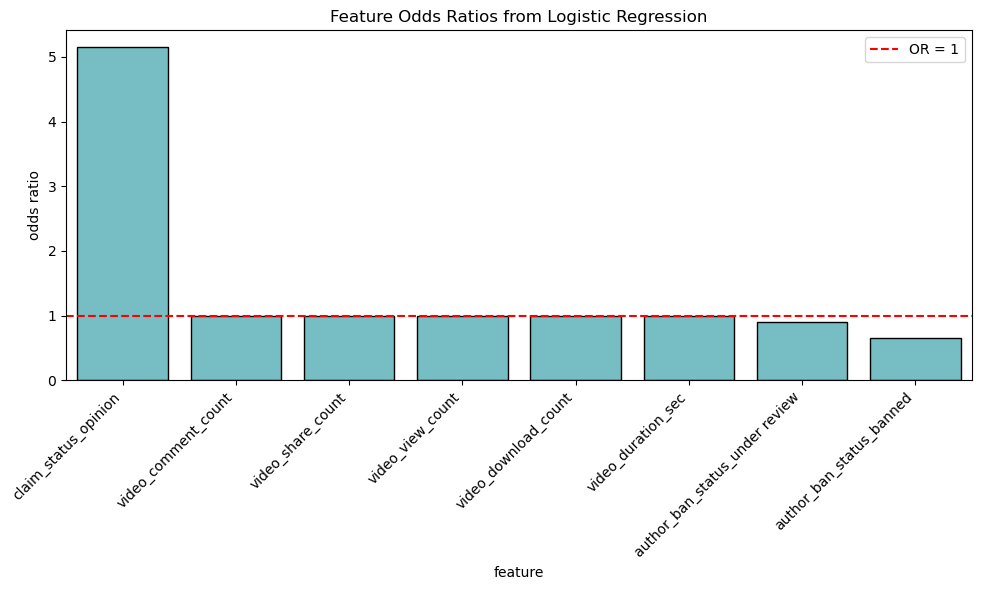

In [21]:
# Get odds ratios and sort them
coef_series = pd.Series(
    np.exp(log_reg.coef_[0]),
    index=list(X_train.drop(columns=['claim_status', 'author_ban_status']).columns) + ['claim_status_opinion', 'author_ban_status_banned',
       'author_ban_status_under review']
).sort_values(ascending=False)

# Print odds ratios
print(coef_series)

# Prepare a dataframe of odds ratios
coef_df = coef_series.reset_index()
coef_df.columns = ['feature', 'odds_ratio']

# Plot a bar chart of odds ratios
plt.figure(figsize=(10, 6))
sns.barplot(
    data=coef_df,
    x='feature',
    y='odds_ratio',
    color='#69C9D0',
    edgecolor='black'
)
# Add a reference line at OR = 1 (no effect)
plt.axhline(1, linestyle='--', color='red', label='OR = 1')
plt.xticks(rotation=45, ha='right')
plt.xlabel('feature')
plt.ylabel('odds ratio')
plt.title('Feature Odds Ratios from Logistic Regression')
plt.legend()
plt.tight_layout()
plt.show()


### **Key takeaways for the TikTok data team lead** ---

- The dataset has a few strongly correlated variables, which might lead to multicollinearity issues when fitting a logistic regression model. We decided to drop video_like_count from the model building.

- The odds ratio for claim_status_opinion (~4.4) shows that “opinion” channels are over four times more likely to be verified, while video‑level metrics hover around 1 (minimal effect) and author bans substantially reduce verification odds (under review ≈ 0.78, banned ≈ 0.60).

- Model performance: for the verified class the classifier achieves a precision of ~ 0.63 and a recall of ~ 0.82, meaning it correctly identifies 82 % of verified channels, though roughly one in three positive predictions is a false alarm.